In [1]:
!pip install pandas tensorflow scikit-learn nltk textblob


In [2]:

import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout


nltk.download('vader_lexicon')

# Load the dataset
data=pd.read_csv('preprocessed_combined_clean_datasetfinal.csv')
print(data)

# Drop missing values
data.dropna(inplace=True)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


                                                     text sentiment  \
0                                              respond go   neutral   
1                                      SAD miss San Diego  negative   
2                                              boss bully  negative   
3                                         interview leave  negative   
4                                         son release buy  negative   
...                                                   ...       ...   
247080  wish we could come see you on denser husband l...  negative   
247081  I have wondered about rake to The client has m...  negative   
247082  say good for both of you Enjoy the break - you...  positive   
247083                          But it was worth it ****.  positive   
247084  All this flirting going on - The at smiles say...   neutral   

        text_length  
0              10.0  
1              18.0  
2              10.0  
3              15.0  
4              15.0  
...            

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset


# Step 1: Encode the sentiment labels to integers
le = LabelEncoder()
data['sentiment'] = le.fit_transform(data['sentiment'])

# Step 2: Train-Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['text'], data['sentiment'], test_size=0.2, random_state=42
)

# Step 3: Load Pre-trained BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Step 4: Tokenization Function
def tokenize_data(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# Tokenize training and testing data
train_encodings = tokenize_data(train_texts, tokenizer)
test_encodings = tokenize_data(test_texts, tokenizer)

# Step 5: Convert Data to Tensors
train_labels_tensor = torch.tensor(train_labels.values)
test_labels_tensor = torch.tensor(test_labels.values)

# Step 6: Build DataLoader for Batching
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels_tensor)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from google.colab import files
import torch

# Step 7: Load Pre-trained BERT Model
num_labels = len(le.classes_)  # Number of unique sentiment classes
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 8: Define Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Total training steps (training data length * epochs)
epochs = 3
num_training_steps = len(train_loader) * epochs

# Scheduler for learning rate decay
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Store loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    total_train_accuracy = 0

    for batch in train_loader:
        input_ids, attention_masks, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Accumulate loss and calculate accuracy
        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        total_train_accuracy += (preds == labels).cpu().numpy().mean()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_accuracy = total_train_accuracy / len(train_loader)

    #################################################################
    # Validation phase
    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_masks, labels = [b.to(device) for b in batch]

            outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            # Accumulate loss and calculate accuracy
            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            total_val_accuracy += (preds == labels).cpu().numpy().mean()

    avg_val_loss = total_val_loss / len(test_loader)
    avg_val_accuracy = total_val_accuracy / len(test_loader)

    # Store losses and accuracies
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(avg_train_accuracy)
    val_accuracies.append(avg_val_accuracy)

    # Print the training and validation results for each epoch
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.4f}")
    print(f"  Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}")



# Save the trained BERT model
torch.save(model.state_dict(), 'bert_model.pth')

# Collect predictions after training is completed
all_preds = []
all_true_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_masks, labels = [b.to(device) for b in batch]

        # Get the model's predictions
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Create a DataFrame to store the predictions and true labels
df = pd.DataFrame({'prediction': all_preds, 'true_label': all_true_labels})

# Save the DataFrame to a CSV file
df.to_csv('bert_predictions.csv', index=False)
# Download the CSV file
files.download('bert_predictions.csv')
print("Predictions saved successfully to 'bert_predictions.csv'")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
  Training Loss: 0.5139, Training Accuracy: 0.7994
  Validation Loss: 0.3382, Validation Accuracy: 0.8794
Epoch 2/3
  Training Loss: 0.2402, Training Accuracy: 0.9166
  Validation Loss: 0.2450, Validation Accuracy: 0.9174
Epoch 3/3
  Training Loss: 0.1255, Training Accuracy: 0.9581
  Validation Loss: 0.2425, Validation Accuracy: 0.9252


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions saved successfully to 'bert_predictions.csv'


In [21]:
# prompt: write code for classificaition report

from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(all_true_labels, all_preds, target_names=le.classes_)

# Print the report
report

'              precision    recall  f1-score   support\n\n    negative       0.93      0.91      0.92     13810\n     neutral       0.91      0.93      0.92     20021\n    positive       0.94      0.93      0.93     15586\n\n    accuracy                           0.93     49417\n   macro avg       0.93      0.92      0.93     49417\nweighted avg       0.93      0.93      0.93     49417\n'

Accuracy: 0.9251


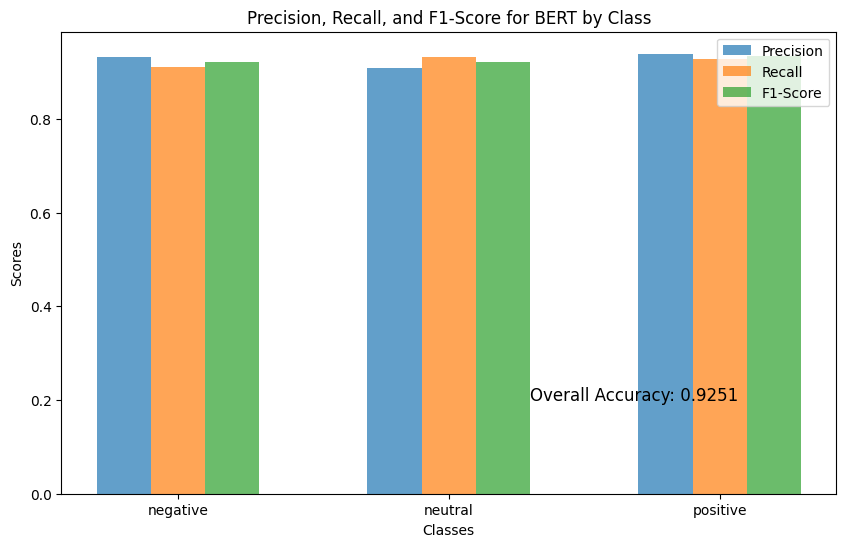

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Assuming 'all_true_labels' and 'all_preds' are your true labels and predicted labels, respectively
# Calculate accuracy
accuracy = accuracy_score(all_true_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report as a dictionary
report = classification_report(all_true_labels, all_preds, target_names=le.classes_, output_dict=True)

# Extract Precision, Recall, F1-Score values for each class
precision = [report[cls]['precision'] for cls in le.classes_]
recall = [report[cls]['recall'] for cls in le.classes_]
f1_score = [report[cls]['f1-score'] for cls in le.classes_]

# Class labels
classes = le.classes_

# Set width of bars
bar_width = 0.2
index = np.arange(len(classes))

# Plot Precision, Recall, and F1-Score for each class
plt.figure(figsize=(10, 6))

# Plotting precision, recall, and f1-score
plt.bar(index, precision, bar_width, label='Precision', alpha=0.7)
plt.bar(index + bar_width, recall, bar_width, label='Recall', alpha=0.7)
plt.bar(index + 2 * bar_width, f1_score, bar_width, label='F1-Score', alpha=0.7)

# Set the x ticks and labels
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1-Score for BERT by Class')
plt.xticks(index + bar_width, classes)

# Add accuracy as text
plt.text(len(classes) - 1.5, 0.2, f'Overall Accuracy: {accuracy:.4f}', fontsize=12, color='black')

# Add legend
plt.legend()

# Display the plot
plt.show()


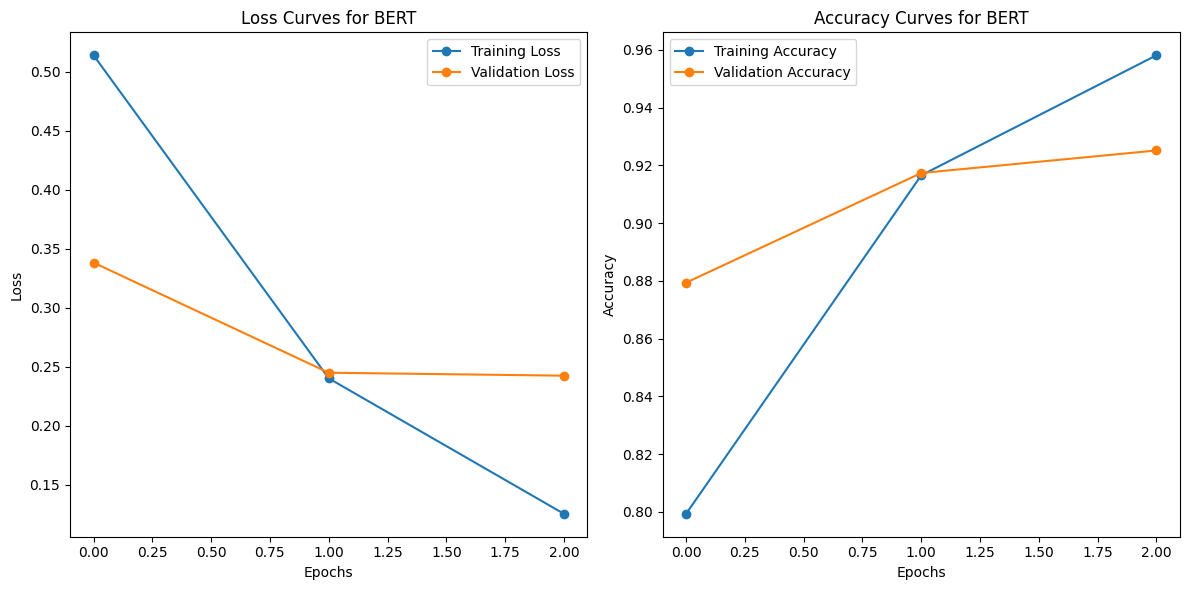

In [5]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss/Accuracy Curves
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    # Loss Curves
    plt.figure(figsize=[12, 6])

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves for BERT')
    plt.legend()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves for BERT')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

# Example call to the function
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)


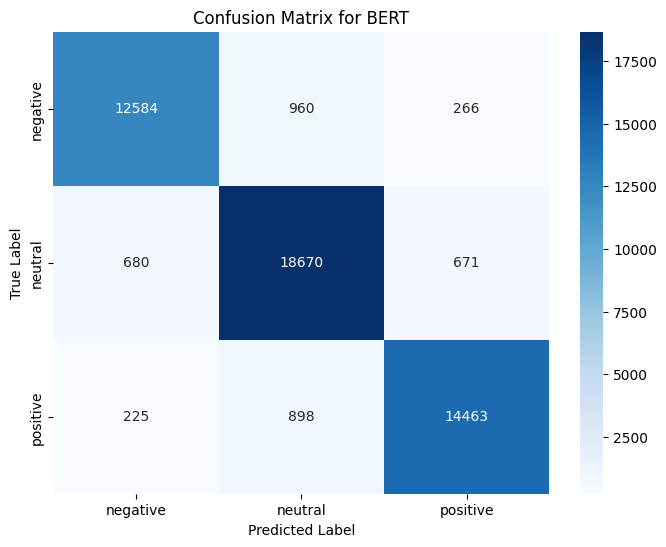

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Confusion Matrix using Seaborn
def plot_confusion_matrix(true_labels, predictions, class_labels):
    # Generate the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for BERT')
    plt.show()

# Example call to the function
plot_confusion_matrix(all_true_labels, all_preds, le.classes_)


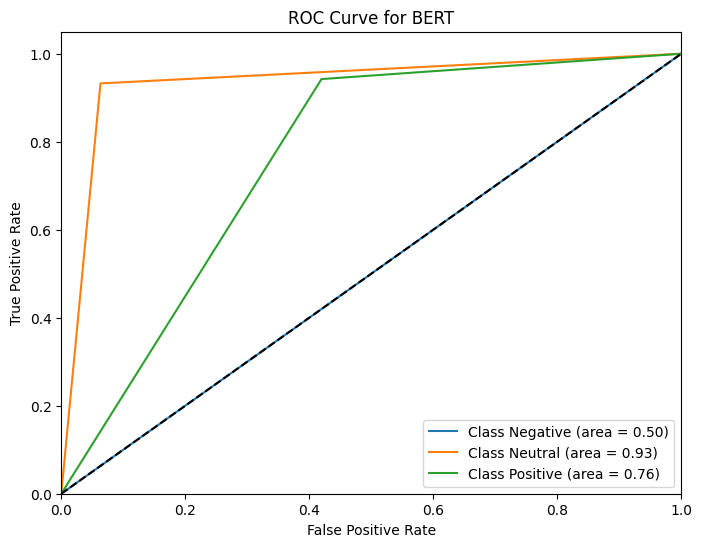

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have 'all_preds' (predicted probabilities) and 'all_true_labels' (true labels)

# Binarize the labels for multi-class ROC curve
y_true_binarized = label_binarize(all_true_labels, classes=np.unique(all_true_labels))
n_classes = y_true_binarized.shape[1]

# Assuming 'all_preds' contains predicted class labels (not probabilities)
# Convert to one-hot encoding representing probabilities
predicted_probabilities = np.zeros((len(all_preds), n_classes))
for i, pred in enumerate(all_preds):
    # Set probability to 1 for predicted class, considering class mapping
    predicted_probabilities[i, pred if pred != 0 else 2] = 1  # Class 0 maps to 2 (positive)

# Convert to PyTorch tensor if needed
predicted_probabilities = torch.tensor(predicted_probabilities).float()

# Compute ROC curve and AUC for each class (considering class mapping)
fpr = dict()
tpr = dict()
roc_auc = dict()
class_names = {0: "Negative", 1: "Neutral", 2: "Positive"}  # Define class names
for i in range(n_classes):
    # Use class names for better visualization
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], predicted_probabilities[:, i].numpy())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for BERT')
plt.legend(loc="lower right")
plt.show()

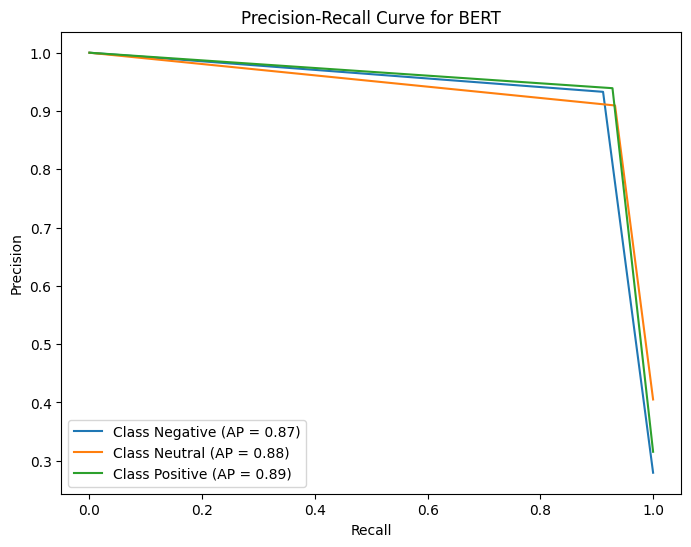

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Assuming you have 'all_preds' (predicted probabilities) and 'all_true_labels' (true labels)

# Binarize the labels for multi-class precision-recall curve
y_true_binarized = label_binarize(all_true_labels, classes=np.unique(all_true_labels))
n_classes = y_true_binarized.shape[1]

class_names = {0: "Negative", 1: "Neutral", 2: "Positive"}  # Define class names

# Assuming 'all_preds' contains predicted class labels (not probabilities)
# Convert to one-hot encoding representing probabilities
predicted_probabilities = np.zeros((len(all_preds), n_classes))
for i, pred in enumerate(all_preds):
    predicted_probabilities[i, pred] = 1  # Set probability to 1 for predicted class

# Compute Precision-Recall curve and Average Precision for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    # Use predicted probabilities for precision-recall calculation
    precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], predicted_probabilities[:, i])
    average_precision[i] = average_precision_score(y_true_binarized[:, i], predicted_probabilities[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label='Class {0} (AP = {1:0.2f})'.format(class_names[i], average_precision[i]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for BERT')
plt.legend(loc="lower left")
plt.show()

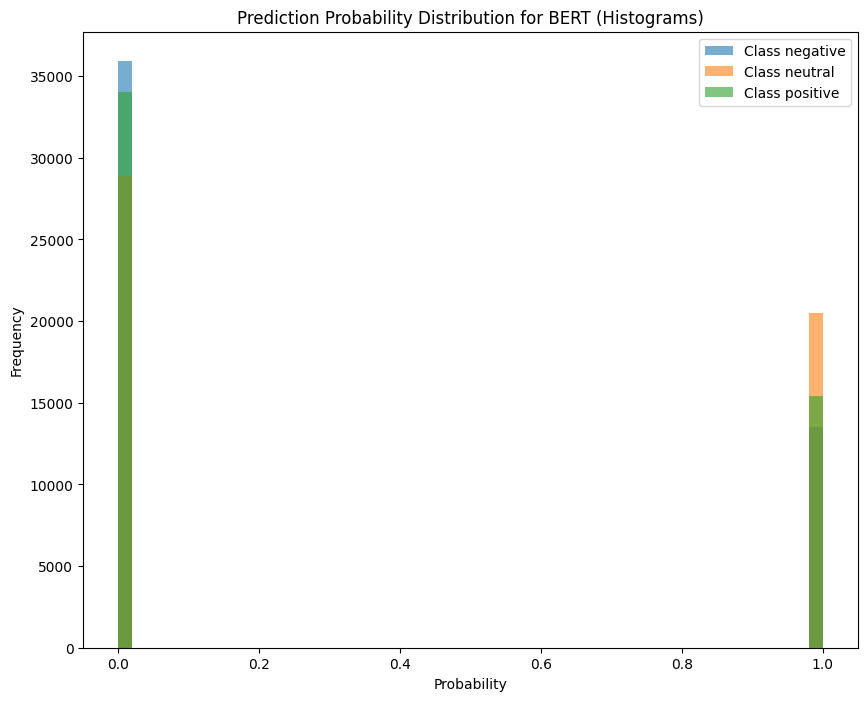

In [18]:
# prompt: Prediction Probability Distribution for BERT (Histograms),write code like below; # Prediction probabilities (before taking argmax)
# cnn_probabilities = model.predict(X_test)
# # Plot histograms of prediction probabilities for each class
# plt.figure(figsize=(10, 8))
# for i in range(len(le.classes_)):
#     plt.hist(cnn_probabilities[:, i], bins=50, alpha=0.6, label=f"Class {le.classes_[i]}")
# plt.title('Prediction Probability Distribution for CNN (Histograms)')
# plt.xlabel('Probability')
# plt.ylabel('Frequency')
# plt.legend(loc='upper right')
# plt.show()

# Assuming you have 'all_preds' (predicted probabilities) and 'all_true_labels' (true labels)
bert_probabilities = predicted_probabilities  # Assuming predicted_probabilities contains probability scores

# Plot histograms of prediction probabilities for each class
plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    plt.hist(bert_probabilities[:, i], bins=50, alpha=0.6, label=f"Class {le.classes_[i]}")
plt.title('Prediction Probability Distribution for BERT (Histograms)')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

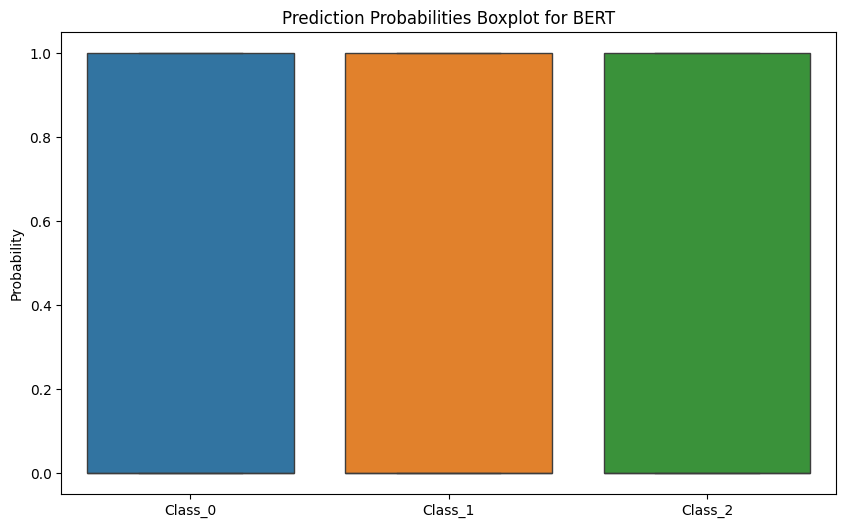

In [20]:
# prompt: write fox boxplot for bert like below; import seaborn as sns
# import pandas as pd
# # Convert probabilities to a DataFrame for visualization
# df_probabilities = pd.DataFrame(cnn_probabilities, columns=[f"Class_{i}" for i in range(len(le.classes_))])
# # Create box plots
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=df_probabilities)
# plt.title('Prediction Probabilities Boxplot for CNN')
# plt.ylabel('Probability')
# plt.show()

# Convert probabilities to a DataFrame for visualization
df_probabilities = pd.DataFrame(bert_probabilities, columns=[f"Class_{i}" for i in range(len(le.classes_))])

# Create box plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_probabilities)
plt.title('Prediction Probabilities Boxplot for BERT')
plt.ylabel('Probability')
plt.show()